In [1]:
# Importing the libraries

import pandas as pd 
import numpy as np 
import yfinance as yf 
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression

In [2]:
# Importing any two assets for relation check

df_appl = yf.download(tickers="AAPL", start="2015-01-01", end="2020-01-01")
df_msft = yf.download(tickers="MSFT", start="2015-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculating the returns of the 2 assets

df_comb = pd.DataFrame()
df_comb["AAPL"] = df_appl["Adj Close"].pct_change().dropna()
df_comb["MSFT"] = df_msft["Adj Close"].pct_change().dropna()

In [4]:
df_comb 

,AAPL,MSFT
Date,,
2015-01-02,-0.009513,0.006674
2015-01-05,-0.028172,-0.009196
2015-01-06,0.000094,-0.014678
2015-01-07,0.014022,0.012705
2015-01-08,0.038422,0.029418
...,...,...
2019-12-23,0.016318,0.000000
2019-12-24,0.000951,-0.000191
2019-12-26,0.019840,0.008197


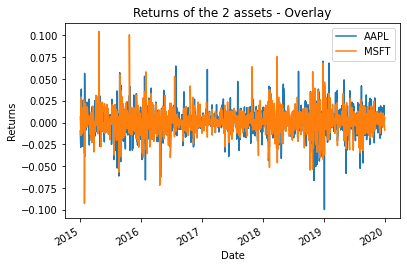

In [5]:
df_comb.plot() 
plt.title("Returns of the 2 assets - Overlay")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show() 

In [6]:
def cointegration(res_test, res_crit, crit_level):
    test_stat = res_test[0]
    if crit_level==90:
        crit_test = res_crit[0][0]
    elif crit_level==95:
        crit_test = res_crit[0][1]
    elif crit_level==99:
        crit_test = res_crit[0][2]
    else:
        raise("Critical level should be any of these 90/95/99")
    print("Test staistic: {} and critical level staistic: {}".format(test_stat, crit_test))

In [7]:
# Checking the assets long term relation using the cointegration
# Null hypothesis (H0): Time series is not cointegrated
# Alternative hypothesis (H1) : Time series is cointegrated
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [8]:
x = np.array(df_comb)
jres = coint_johansen(x, det_order=0, k_ar_diff=1)

In [9]:
# If eigen test statistic is greater than at 95% level statistics we
# reject null hypothesis and accept the alternative hypothesis
# https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/

In [10]:
cointegration(jres.max_eig_stat, jres.max_eig_stat_crit_vals,95)

Test staistic: 618.7390674240481 and critical level staistic: 14.2639


In [11]:
# since test statistic > critical level we rejecr H0 and accept H1

In [12]:
X = df_comb["AAPL"].values
Y = df_comb["MSFT"].values 

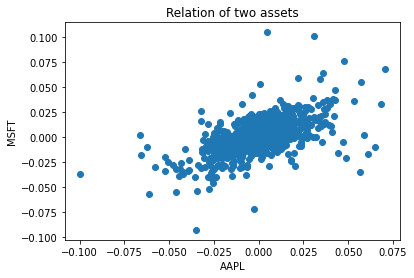

In [13]:
plt.scatter(X,Y)
plt.title("Relation of two assets")
plt.xlabel("AAPL")
plt.ylabel("MSFT")
plt.show() 

In [14]:
lookback = 50

In [15]:
# Sliding window prediction

actual_ = []
predicted_ = []
testreturn_ = []
for i in range(lookback, X.shape[0]):
    xtrain = X[i-lookback:i].reshape(-1,1)
    ytrain = Y[i-lookback:i]
    reg = LinearRegression().fit(xtrain, ytrain)
    actual_.append(Y[i])
    testreturn_.append(X[i])
    predicted_.append(float(reg.predict(X[i].reshape(-1,1))))

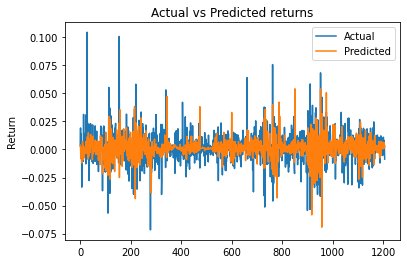

In [16]:
plt.plot(actual_, label="Actual")
plt.plot(predicted_, label ="Predicted")
plt.title("Actual vs Predicted returns")
plt.ylabel("Return")
plt.legend()
plt.show()

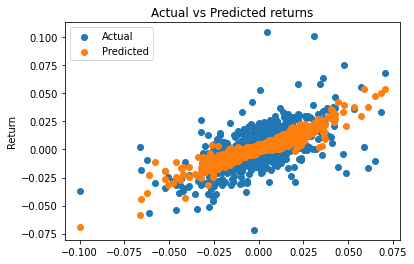

In [17]:
plt.scatter(testreturn_, actual_, label="Actual")
plt.scatter(testreturn_, predicted_, label = "Predicted")
plt.title("Actual vs Predicted returns")
plt.ylabel("Return")
plt.legend()
plt.show()

In [18]:
df_pred = df_comb.copy()
df_pred = df_pred.iloc[lookback:, :]
df_pred["MSFT_predicted_return"] = predicted_
df_pred 

,AAPL,MSFT,MSFT_predicted_return
Date,,,
2015-03-17,0.016727,0.003369,0.003852
2015-03-18,0.011256,0.019185,0.001409
2015-03-19,-0.007550,-0.004941,-0.006526
2015-03-20,-0.012549,0.013952,-0.008409
2015-03-23,0.010405,-0.000466,0.001704
...,...,...,...
2019-12-23,0.016318,0.000000,0.005498
2019-12-24,0.000951,-0.000191,0.001807
2019-12-26,0.019840,0.008197,0.006337


In [19]:
# Signal: If predicted return > 0 go long and predicted return < 0 go short else no trade
df_pred["allocation"] = np.where(df_pred["MSFT_predicted_return"]>0, 0.2, (np.where(
                                    df_pred["MSFT_predicted_return"]<0, -0.2, 0.0)))

In [20]:
df_pred 

,AAPL,MSFT,MSFT_predicted_return,allocation
Date,,,,
2015-03-17,0.016727,0.003369,0.003852,0.2
2015-03-18,0.011256,0.019185,0.001409,0.2
2015-03-19,-0.007550,-0.004941,-0.006526,-0.2
2015-03-20,-0.012549,0.013952,-0.008409,-0.2
2015-03-23,0.010405,-0.000466,0.001704,0.2
...,...,...,...,...
2019-12-23,0.016318,0.000000,0.005498,0.2
2019-12-24,0.000951,-0.000191,0.001807,0.2
2019-12-26,0.019840,0.008197,0.006337,0.2


In [21]:
# Including close price data for backtest

df_pred["AAPL_close"] = df_appl["Adj Close"].iloc[lookback:]
df_pred["MSFT_close"] = df_msft["Adj Close"].iloc[lookback:]

In [22]:
df_pred

,AAPL,MSFT,MSFT_predicted_return,allocation,AAPL_close,MSFT_close
Date,,,,,,
2015-03-17,0.016727,0.003369,0.003852,0.2,28.868002,36.997601
2015-03-18,0.011256,0.019185,0.001409,0.2,29.192949,37.707390
2015-03-19,-0.007550,-0.004941,-0.006526,-0.2,28.972530,37.521061
2015-03-20,-0.012549,0.013952,-0.008409,-0.2,28.608955,38.044540
2015-03-23,0.010405,-0.000466,0.001704,0.2,28.906628,38.026798
...,...,...,...,...,...,...
2019-12-23,0.016318,0.000000,0.005498,0.2,69.960800,154.465195
2019-12-24,0.000951,-0.000191,0.001807,0.2,70.027306,154.435699
2019-12-26,0.019840,0.008197,0.006337,0.2,71.416679,155.701599


In [29]:
import sys
sys.path.append('../')

In [30]:
# Infertrade backtest

from infertrade.utilities.performance import calculate_portfolio_performance_python

In [31]:
df_pred = df_pred.rename(columns={'MSFT_close':'close'})

In [32]:
df_port = calculate_portfolio_performance_python(df_with_positions=df_pred)

In [33]:
df_pred

,AAPL,MSFT,MSFT_predicted_return,allocation,AAPL_close,close,price,period_start_cash,period_start_securities,start_of_period_allocation,trade_percentage,trading_skipped,period_end_cash,period_end_securities,end_of_period_allocation,security_purchases,cash_flow,portfolio_return
Date,,,,,,,,,,,,,,,,,,
2015-03-17,0.016727,0.003369,0.003852,0.2,28.868002,36.997601,36.997601,1.000000,0.000000,0.000000,0.200000,0.0,0.800000,0.005406,0.2,5.405756e-03,-0.200000,1.000000
2015-03-18,0.011256,0.019185,0.001409,0.2,29.192949,37.707390,37.707390,0.800000,0.005406,0.203058,-0.003058,0.0,0.803070,0.005324,0.2,-8.140468e-05,0.003070,1.003837
2015-03-19,-0.007550,-0.004941,-0.006526,-0.2,28.972530,37.521061,37.521061,0.803070,0.005324,0.199209,-0.399209,0.0,1.203414,-0.005346,-0.2,-1.066986e-02,0.400344,1.002845
2015-03-20,-0.012549,0.013952,-0.008409,-0.2,28.608955,38.044540,38.044540,1.203414,-0.005346,-0.203358,0.003358,0.0,1.200056,-0.005257,-0.2,8.826270e-05,-0.003358,1.000047
2015-03-23,0.010405,-0.000466,0.001704,0.2,28.906628,38.026798,38.026798,1.200056,-0.005257,-0.199888,0.399888,0.0,0.800112,0.005260,0.2,1.051743e-02,-0.399944,1.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016318,0.000000,0.005498,0.2,69.960800,154.465195,154.465195,0.935664,0.001514,0.200000,0.000000,0.0,0.935664,0.001514,0.2,0.000000e+00,0.000000,1.169580
2019-12-24,0.000951,-0.000191,0.001807,0.2,70.027306,154.435699,154.435699,0.935664,0.001514,0.199969,0.000031,0.0,0.935628,0.001515,0.2,2.313787e-07,-0.000036,1.169535
2019-12-26,0.019840,0.008197,0.006337,0.2,71.416679,155.701599,155.701599,0.935628,0.001515,0.201309,-0.001309,0.0,0.937162,0.001505,0.2,-9.851257e-06,0.001534,1.171452


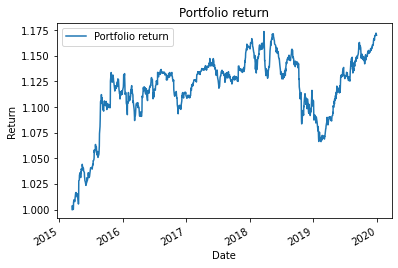

In [34]:
df_pred["portfolio_return"].plot(label="Portfolio return") 
plt.title("Portfolio return")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend() 
plt.show() 

In [35]:
from infertrade_pyfolio.wrapper import InfertradePyfolio
import empyrical as ep 

C:\anaconda3\envs\infertradenv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


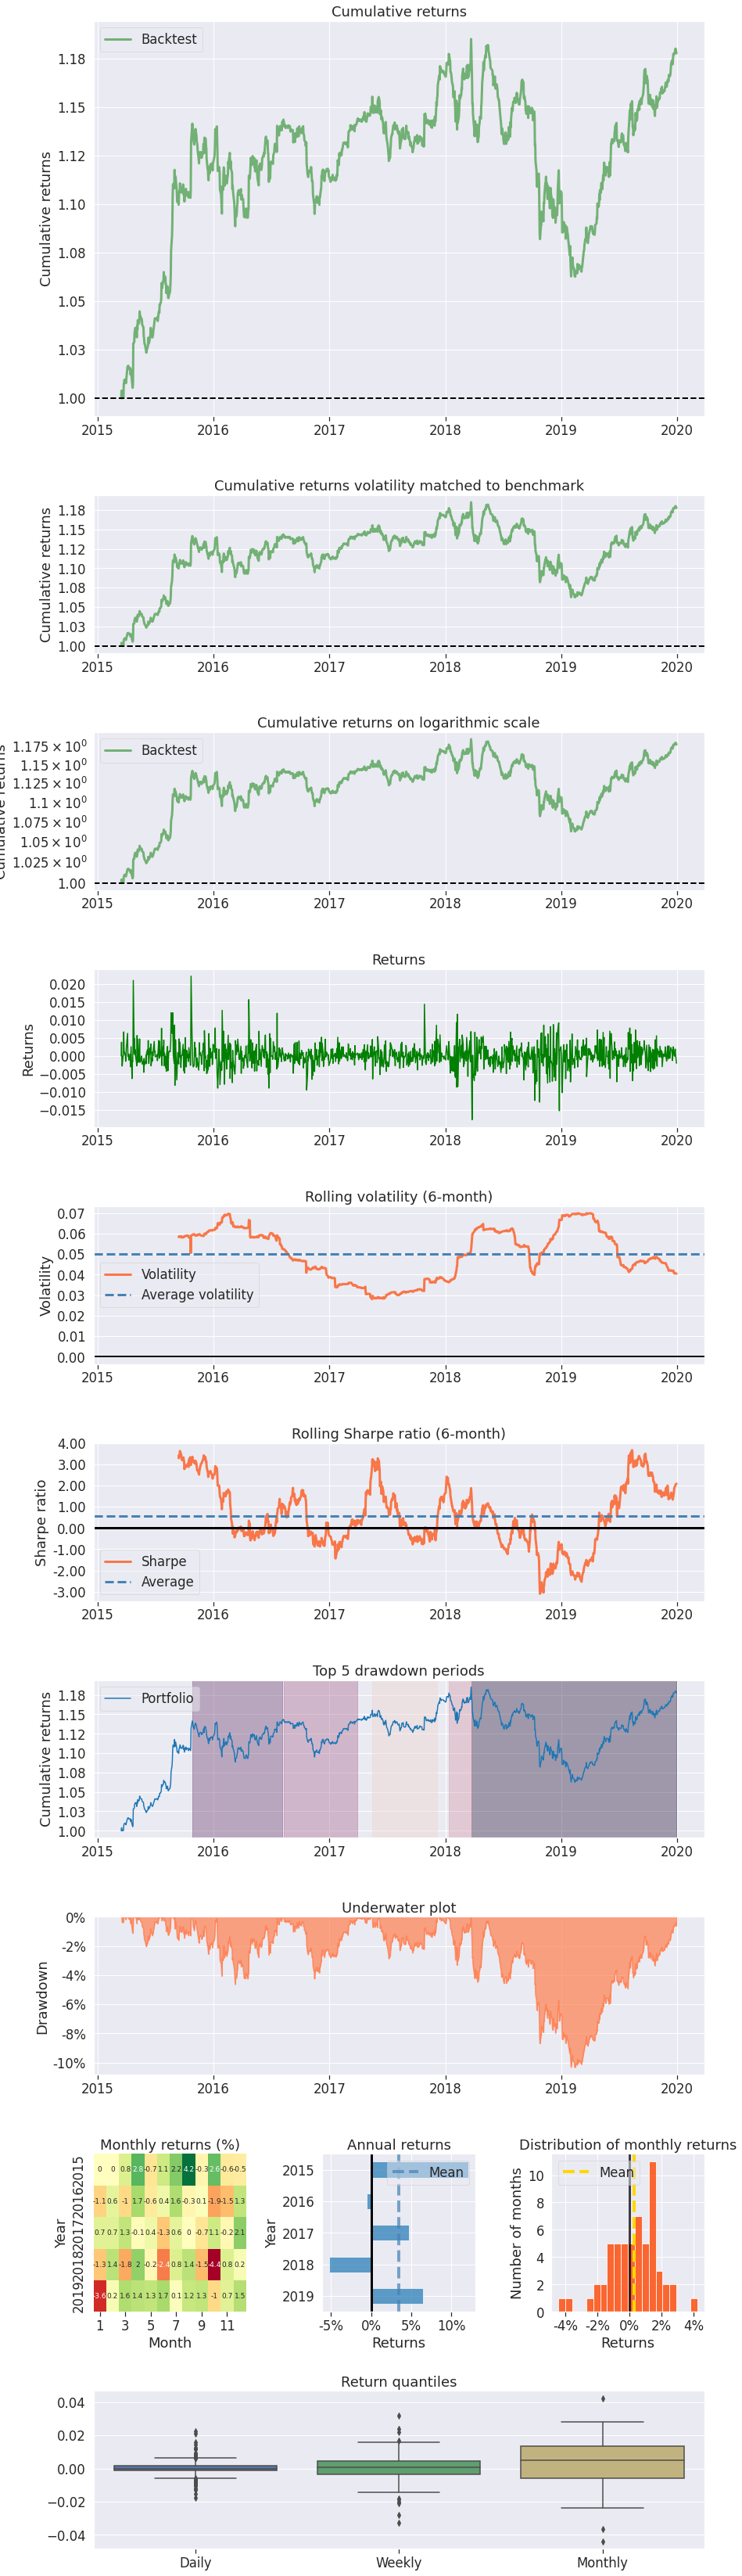

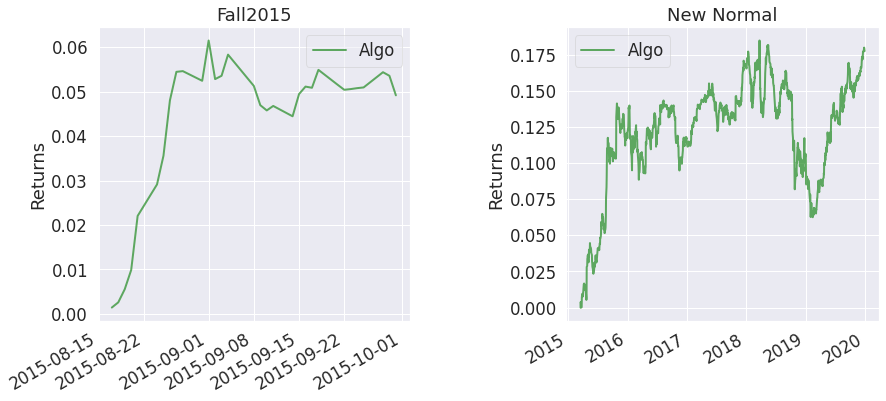

In [36]:
InfertradePyfolio.infertrade_full_tear_sheet(returns=df_pred["portfolio_return"].diff().fillna(0.0), notebook=True, pdf=False)